# Major updates:
#### added LogisticAT model for ordinal regression
    https://home.ttic.edu/~nati/Publications/RennieSrebroIJCAI05.pdf
    https://pythonhosted.org/mord/reference.html#mord.MulticlassLogistic
#### changed accuracy prediction function, using sklearn.metrics.accuracy_score
    https://stackoverflow.com/questions/56621252/negative-accuracy-score-in-regression-models-with-scikit-learn
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [1]:
import numpy as np
import pandas as pd
import re
import nltk

In [2]:
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.shape

(14640, 15)

In [4]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

In [5]:
df['text'] = df['text'].apply(preprocessor)
df['text'].head()

0                    virginamerica what dhepburn said 
1     virginamerica plus you ve added commercials t...
2     virginamerica i didn t today must mean i need...
3     virginamerica it s really aggressive to blast...
4     virginamerica and it s a really big bad thing...
Name: text, dtype: object

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [46]:
from sklearn.model_selection import train_test_split


y = df['airline_sentiment'].values
X = df['text'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y)

In [8]:
# Processing documents into tokens
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

def tokenizer(text):
    return text.split()

In [9]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [10]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
tfidf = TfidfVectorizer(strip_accents=None,
    lowercase=False,
    preprocessor=None)
param_grid = [{'vect__ngram_range': [(1,1)],
    'vect__stop_words': [stop, None],
    'vect__tokenizer': [tokenizer, tokenizer_porter],
    'clf__C': [1.0, 10.0, 100.0],
    'clf__solver' : ['sag', 'saga', 'newton-cg', 'lbfgs' ],
    'clf__penalty' : ['l2', 'none']
              },
    {'vect__ngram_range': [(1,1)],
     'vect__stop_words': [stop, None],
    'vect__tokenizer': [tokenizer, tokenizer_porter],
    'vect__use_idf':[False],
    'vect__norm':[None],
    'clf__C': [1.0, 10.0, 100.0],
    'clf__solver' : ['sag', 'saga', 'newton-cg', 'lbfgs' ],
    'clf__penalty' : ['l2', 'none']}
    ]
lr_tfidf = Pipeline([('vect', tfidf),
    ('clf', LogisticRegression(random_state=123, penalty = 'l2', multi_class = 'multinomial'))
                    ])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
    scoring='accuracy',
    cv=5, verbose=2,
    n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=123))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l2', 'none'],
                          'clf__solver': ['sag', 'saga', 'newton-cg', 'lbfgs'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', '...
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
    

In [50]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x000002304BC3C310>} 


In [51]:
from sklearn.metrics import accuracy_score  
print('CV Accuracy: %.3f'
    % gs_lr_tfidf.best_score_)
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f'
    % accuracy_score(y_test, clf.predict(X_test)))

CV Accuracy: 0.802
Test Accuracy: 0.805


In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

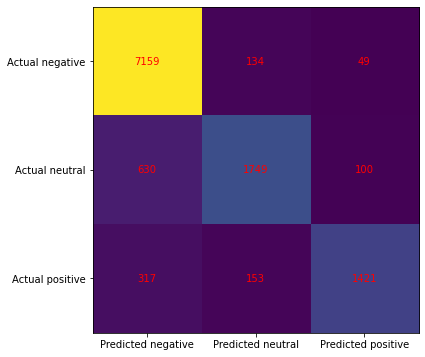

[[7159  134   49]
 [ 630 1749  100]
 [ 317  153 1421]]


In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, clf.predict(X_train))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted negative', 'Predicted neutral', 'Predicted positive'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual negative', 'Actual neutral','Actual positive'))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()
print(cm)

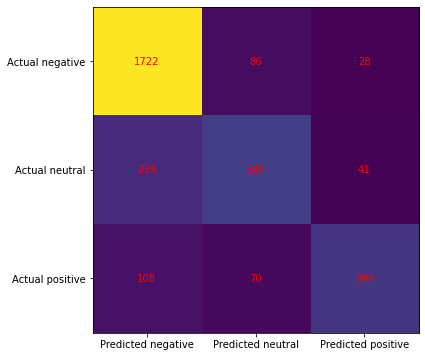

[[1722   86   28]
 [ 239  340   41]
 [ 108   70  294]]


In [17]:
cm = confusion_matrix(y_test, clf.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted negative', 'Predicted neutral', 'Predicted positive'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual negative', 'Actual neutral','Actual positive'))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()
print(cm)

# Oridinal

In [18]:
y_ordinal = df['airline_sentiment'].map({'negative':0, 'neutral':1, 'positive':2}).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y_ordinal, test_size=0.2, random_state=123, stratify=y_ordinal)

In [12]:
#!conda install mord

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - mord


The following NEW packages will be INSTALLED:

  mord               conda-forge/noarch::mord-0.6-py_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [19]:
import mord as m

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
    lowercase=False,
    preprocessor=None)
param_grid = [{'vect__ngram_range': [(1,1)],
    'vect__stop_words': [stop, None],
    'vect__tokenizer': [tokenizer, tokenizer_porter],
    'clf__alpha' : [1.0, 10.0, 100.0]},
    {'vect__ngram_range': [(1,1)],
     'vect__stop_words': [stop, None],
    'vect__tokenizer': [tokenizer, tokenizer_porter],
    'clf__alpha' : [1.0, 10.0, 100.0],
    'vect__use_idf':[False],
    'vect__norm':[None]}
    ]
lrIT_tfidf = Pipeline([('vect', tfidf),
    ('clf',m.LogisticIT())
                    ])

gs_lrIT_tfidf = GridSearchCV(lrIT_tfidf, param_grid,
    scoring='accuracy',
    cv=5, verbose=2,
    n_jobs=-1)

gs_lrIT_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', LogisticIT())]),
             n_jobs=-1,
             param_grid=[{'clf__alpha': [1.0, 10.0, 100.0],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', '...
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'

In [41]:
print('Best parameter set: %s ' % gs_lrIT_tfidf.best_params_)

Best parameter set: {'clf__alpha': 1.0, 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x000002304BC3C310>, 'vect__use_idf': False} 


In [43]:
print('CV Accuracy: %.3f'
    % gs_lrIT_tfidf.best_score_)
clf_IT = gs_lrIT_tfidf.best_estimator_
print('Test Accuracy: %.3f'
    % accuracy_score(y_test, clf_IT.predict(X_test)))

CV Accuracy: 0.771
Test Accuracy: 0.764


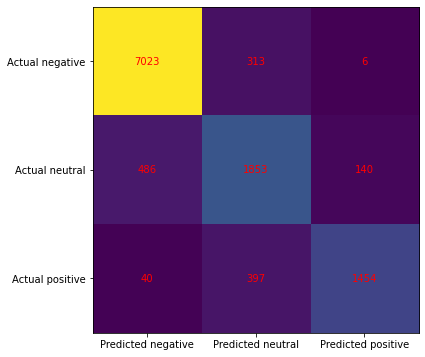

[[7023  313    6]
 [ 486 1853  140]
 [  40  397 1454]]


In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_train, clf_IT.predict(X_train))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted negative', 'Predicted neutral', 'Predicted positive'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual negative', 'Actual neutral','Actual positive'))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()
print(cm)

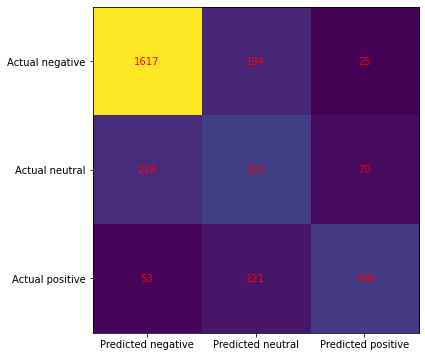

[[1617  194   25]
 [ 228  322   70]
 [  53  121  298]]


In [45]:
cm = confusion_matrix(y_test, clf_IT.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted negative', 'Predicted neutral', 'Predicted positive'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual negative', 'Actual neutral','Actual positive'))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()
print(cm)

# Another Ordinal Attempt with LogisticAT

In [26]:
lrAT_tfidf = Pipeline([('vect', tfidf),
    ('clf',m.LogisticAT())
                    ])

gs_lrAT_tfidf = GridSearchCV(lrAT_tfidf, param_grid,
    scoring='accuracy',
    cv=5, verbose=2,
    n_jobs=-1)

gs_lrAT_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf', LogisticAT())]),
             n_jobs=-1,
             param_grid=[{'clf__alpha': [1.0, 10.0, 100.0],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', '...
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'

In [36]:
print('Best parameter set: %s ' % gs_lrAT_tfidf.best_params_)
print('CV Accuracy: %.3f'
    % gs_lrAT_tfidf.best_score_)
clf_AT = gs_lrAT_tfidf.best_estimator_
print('Test Accuracy: %.3f' % accuracy_score(y_test, clf_AT.predict(X_test)))

Best parameter set: {'clf__alpha': 1.0, 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x000002304BC3C310>, 'vect__use_idf': False} 
CV Accuracy: 0.766
Test Accuracy: 0.758


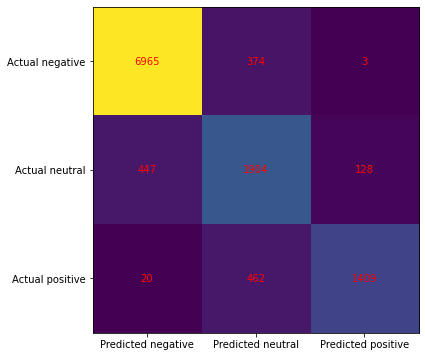

[[6965  374    3]
 [ 447 1904  128]
 [  20  462 1409]]


In [39]:
cm = confusion_matrix(y_train, clf_AT.predict(X_train))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted negative', 'Predicted neutral', 'Predicted positive'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual negative', 'Actual neutral','Actual positive'))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()
print(cm)

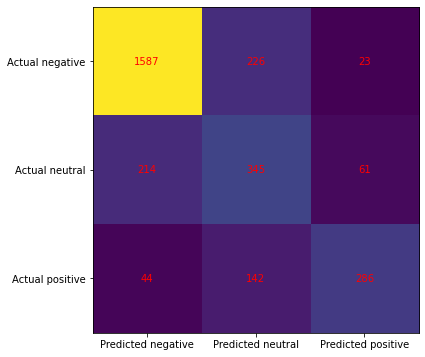

[[1587  226   23]
 [ 214  345   61]
 [  44  142  286]]


In [38]:
cm = confusion_matrix(y_test, clf_AT.predict(X_test))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted negative', 'Predicted neutral', 'Predicted positive'))
ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual negative', 'Actual neutral','Actual positive'))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()
print(cm)